# MiniLM

## 1. Setup

In [70]:
import math
import copy
from tqdm.auto import tqdm

import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForMaskedLM
from transformers import BatchEncoding
from transformers.data.data_collator import DataCollatorForWholeWordMask, DataCollatorForLanguageModeling
from datasets import load_dataset

## 2. Model

In [2]:
def to_distill(model):
    # class method
    model.base_model.encoder.layer[0].attention.self.__class__._forward = bert_self_attention_forward

    # instance method
    for layer in model.base_model.encoder.layer:
        layer.attention.self.forward = layer.attention.self._forward
    
    return model

def get_qkvs(model):
    attns = [l.attention.self for l in model.base_model.encoder.layer]
    qkvs = [{'q': a.q, 'k': a.k, 'v': a.v} for a in attns]    
    return qkvs


def relation_attention(h, num_relation_heads, attention_mask=None):        
    batch_size, seq_length, dim = h.size()
    relation_head_size = dim // num_relation_heads

    h = h.view(batch_size, seq_length, num_relation_heads, relation_head_size)
    h = h.permute(0, 2, 1, 3) # (batch_size, num_relation_heads, seq_length, attention_head_size)

    attn = torch.matmul(h, h.transpose(-1, -2)) # (batch_size, num_relation_heads, seq_length, seq_length)
    if attention_mask is not None:
        attention_mask = attention_mask[:, None, None, :]
        attention_masks = (1 - attention_mask) * -10000.0
        attn = attn + attention_mask

    attn = attn.view(-1, seq_length)
    return attn

def minilm_loss(t, s, num_relation_heads, attention_mask=None):
    attn_t = relation_attention(t, num_relation_heads, attention_mask)
    attn_s = relation_attention(s, num_relation_heads, attention_mask)
    loss = F.kl_div(F.log_softmax(attn_s, dim=-1), F.softmax(attn_t, dim=-1), reduction='batchmean')
    return loss


def bert_self_attention_forward(
    self,
    hidden_states,
    attention_mask=None,
    head_mask=None,
    encoder_hidden_states=None,
    encoder_attention_mask=None,
    past_key_value=None,
    output_attentions=False,
):
    mixed_query_layer = self.query(hidden_states)
    mixed_key_layer = self.key(hidden_states)
    mixed_value_layer = self.value(hidden_states)
    
    query_layer = self.transpose_for_scores(mixed_query_layer)
    key_layer = self.transpose_for_scores(mixed_key_layer)
    value_layer = self.transpose_for_scores(mixed_value_layer)
    
    self.q = mixed_query_layer # (Batch, Seq, Dim)
    self.k = mixed_key_layer # (Batch, Seq, Dim)
    self.v = mixed_value_layer # (Batch, Seq, Dim)

    if self.is_decoder:
        past_key_value = (key_layer, value_layer)

    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

    if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
        seq_length = hidden_states.size()[1]
        position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
        position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
        distance = position_ids_l - position_ids_r
        positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
        positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

        if self.position_embedding_type == "relative_key":
            relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores
        elif self.position_embedding_type == "relative_key_query":
            relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

    attention_scores = attention_scores / math.sqrt(self.attention_head_size)
    if attention_mask is not None:
        attention_scores = attention_scores + attention_mask

    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    attention_probs = self.dropout(attention_probs)

    if head_mask is not None:
        attention_probs = attention_probs * head_mask

    context_layer = torch.matmul(attention_probs, value_layer)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
    context_layer = context_layer.view(*new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
    if self.is_decoder:
        outputs = outputs + (past_key_value,)
    return outputs

In [18]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForMaskedLM.from_pretrained('klue/bert-base')

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model = to_distill(model)

In [62]:
dataset = load_dataset('text', data_files='../data/modu-spoken.txt')['train']

Using custom data configuration default-077c9c975f10ac3b
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-077c9c975f10ac3b/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)


  0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
dataset.set_transform(lambda batch: tokenizer(batch['text'], return_tensors='pt', max_length=512, truncation=True, padding='max_length', return_token_type_ids=False))

In [72]:
# collator = DataCollatorForWholeWordMask(tokenizer)
collator = DataCollatorForLanguageModeling(tokenizer, mlm=True)

In [149]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collator)

In [284]:
d = next(iter(loader))

In [285]:
o = model(**d)

In [286]:
qkvs = get_qkvs(model)

In [337]:
attn = relation_attention(qkvs[-1]['q'], num_relation_heads=48, attention_mask=d['attention_mask'])
attn /= 2.
attn = attn.softmax(dim=1)

In [338]:
attn2 = relation_attention(qkvs[9]['q'], num_relation_heads=48, attention_mask=d['attention_mask'])
attn2 /= 2.
attn2 = attn2.softmax(dim=1)

In [339]:
(attn > 1e-5).float().mean()

tensor(0.6760)

In [340]:
(attn2 > 1e-5).float().mean()

tensor(0.6498)

In [344]:
idx = 160

<AxesSubplot:>

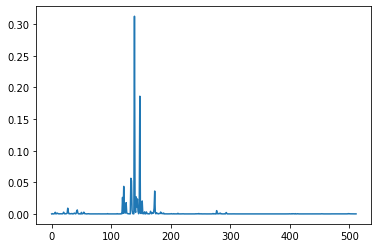

In [345]:
sns.lineplot(x=range(512), y=attn[idx])

<AxesSubplot:>

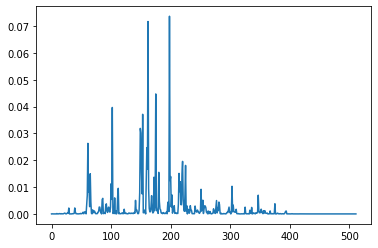

In [346]:
sns.lineplot(x=range(512), y=attn2[idx])